In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random
import time
from functools import partial
%matplotlib inline

# 10-armed bandit

The bandit:
- Mean and variance for each arm. The means represent $Q^*(a)$
- Ability to interact with the bandit - specifically simulate a play on one of its arms
- Bandit represented as a 2D array - rows are arms, columns are (mean, variance)
- Bandit array built by generating 10 means (from a guassian, mean 0 and variance 1), variances are 1

The agent:
- Maintains:
  - list of estimates of $Q_t(a)$ (Estimated value of each action $a$)
  - Current "play" number $k$
- Determines action to take, given $Q_t(a)$ and $k$

Running plays:
- Ask agent for an agent
- Get response from bandit for action
- Give response to agent

In [2]:
class Bandit(object):
    def __init__(self, mean_variances):
        self.mean_variances = mean_variances
    
    def get_response(self, arm_index):
        mean, variance = self.mean_variances[arm_index]
        return np.random.normal(mean, variance)
    
    def optimal_action(self):
        return np.argmax([mean_var[0] for mean_var in self.mean_variances])

def make_bandit(n_arms,
                mean_reward_mean=0, var_reward_mean=1,
                mean_reward_var=1, var_reward_var=0,
                BanditType=Bandit):
    mean_vars =  [
        (
            np.random.normal(mean_reward_mean, var_reward_mean),
            np.random.normal(mean_reward_var, var_reward_var)
        ) for _ in range(n_arms)
    ]
    return BanditType(mean_vars)

In [20]:
class NonStationaryBandit(Bandit):
    def get_response(self, arm_index):
        """Update the arm means after each"""
        response = super().get_response(arm_index)
        new_mean_vars = []
        for mean, var in self.mean_variances:
            mean = mean * (1 + np.random.uniform(-0.05, 0.05))
            new_mean_vars.append((mean, var))
        self.mean_variances = new_mean_vars
        return response

In [26]:
class Agent(object):
    def __init__(self, estimated_action_values, explore_chance=0):
        self.estimated_action_values = estimated_action_values
        self.action_counts = [0 for _ in range(len(self.estimated_action_values))]
        self.explore_chance = explore_chance
        self.rewards = []
    
    def get_action(self):
        best = self.preferred_action()
        if self.should_explore():
            action = self.exploratory_action()
        else:
            action = best
        self.action_counts[action] += 1
        return action
        
    def preferred_action(self):
        max_action_val = np.max(self.estimated_action_values)
        return random.choice(np.argwhere(self.estimated_action_values == max_action_val))[0]
    
    def should_explore(self):
        return np.random.random() < self.explore_chance
    
    def exploratory_action(self):
        max_action_val = np.max(self.estimated_action_values)
        less_max_action_val = np.argwhere(self.estimated_action_values != max_action_val)
        if len(less_max_action_val):
            return random.choice(less_max_action_val)[0]
        else:
            return random.choice(list(range(len(self.estimated_action_values))))
    
    def update(self, action, reward):
        self.rewards.append(reward)
        action_value = self.estimated_action_values[action]
        action_times_used = self.action_counts[action]
        new_action_value = action_value + self.step_size_fn(action_times_used) * (reward - action_value)
        self.estimated_action_values[action] = new_action_value
        
    def step_size_fn(self, action_times_used):
        return 1 / action_times_used
        
    def mean_reward(self):
        return np.mean(self.rewards)
    

class ConstantStepSizeAgent(Agent):
    def __init__(self, estimated_action_values, explore_chance=0, step_size=0.1):
        super().__init__(estimated_action_values, explore_chance=explore_chance)
        self.step_size = step_size
        
    def step_size_fn(self, action_times_used):
        return self.step_size 

    
def make_agent(bandit_num_arms, initial_estimated_action_value, AgentType=Agent, agent_kwargs={}) -> Agent:
    return AgentType([initial_estimated_action_value for _ in range(bandit_num_arms)], **agent_kwargs)

In [27]:
def iter_plays(bandit, agent, num_plays=1000, print_=False):
    for play_number in range(1, num_plays+1):
        action = agent.get_action()
        print_ and print(f"Agent action values {agent.estimated_action_values}")
        print_ and print(f"Agent chose {action}")
        response = bandit.get_response(action)
        print_ and print(f"Reward: {response}")
        print_ and print("\n##################\n")
        agent.update(action, response)
        print_ and time.sleep(1)
        yield bandit, agent

In [34]:
def run(bandit_factory, agent_factory, repeats=200):
    all_on_optimal_actions = []
    all_mean_rewards = []
    
    for _repeat in range(repeats):
        bandit = bandit_factory()
        agent = agent_factory()
        _repeat % 10 == 0 and print(_repeat, end=', ')
        on_optimal_action = []
        mean_rewards = []
        for bandit, agent in iter_plays(bandit, agent):
            on_optimal_action.append(int(bandit.optimal_action() == agent.preferred_action()))
            mean_rewards.append(agent.mean_reward())
        all_on_optimal_actions.append(on_optimal_action)
        all_mean_rewards.append(mean_rewards)
    
    all_mean_rewards_avg = np.array(all_mean_rewards).mean(axis=0)
    perc_optimal_actions = 100 * np.array(all_on_optimal_actions).mean(axis=0)

    plt.figure()
    plt.title("Mean reward")
    plt.plot(all_mean_rewards_avg)
    plt.xlabel("Play")
    plt.ylabel("Mean reward")
    plt.ylim(-0.5,1.5)
    plt.show()

    plt.figure(figsize=(9,9))
    plt.title("Percentage agents on optimal action")
    plt.plot(perc_optimal_actions)
    plt.xlabel("Play")
    plt.ylabel("% optimal action")
    plt.ylim(0,100)
    plt.show()
    
    return all_mean_rewards_avg, perc_optimal_actions

## Stationary bandit with exponentially decay weighting on previous rewards

0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 

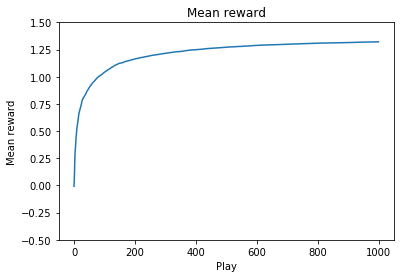

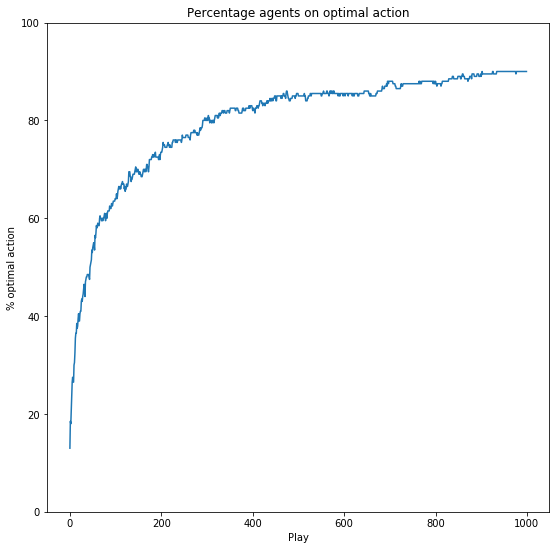

In [35]:
reward_avg, optimal_actions = run(bandit_factory=partial(make_bandit, 10),
                                  agent_factory=partial(make_agent, 10, 0, agent_kwargs={'explore_chance': 0.1}))

## Non-Stationary bandit with equal weighting of previous rewards

0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 

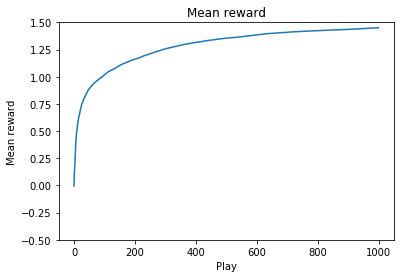

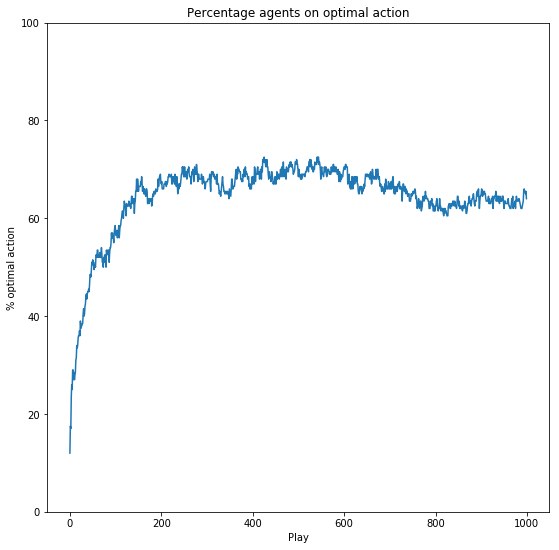

In [36]:
ns_reward_avg, ns_optimal_actions = run(bandit_factory=partial(make_bandit, 10, BanditType=NonStationaryBandit),
                                        agent_factory=partial(make_agent, 10, 0, agent_kwargs={'explore_chance': 0.1}))

## Non-Stationary bandit with exponential decay weighting of previous rewards

0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 

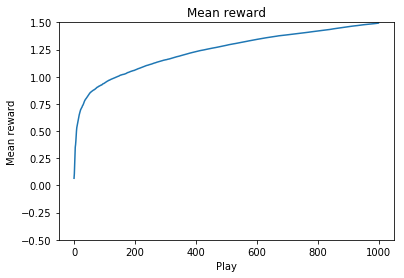

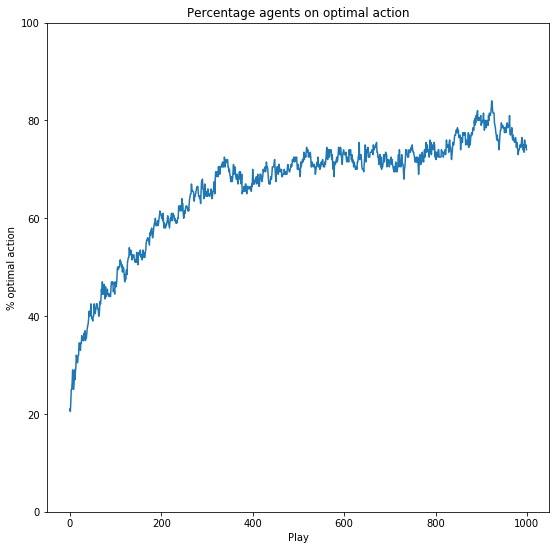

In [37]:
ns_reward_avg, ns_optimal_actions = run(bandit_factory=partial(make_bandit, 10, BanditType=NonStationaryBandit),
                                        agent_factory=partial(make_agent, 10, 0, 
                                                              AgentType=ConstantStepSizeAgent,
                                                              agent_kwargs={'explore_chance': 0.1,
                                                                            'step_size': 0.1}))

### Halve the step size

0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 

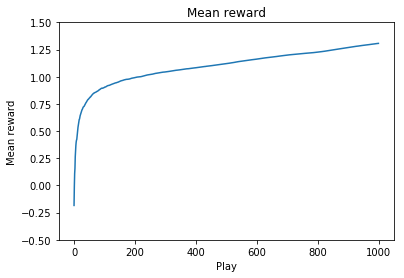

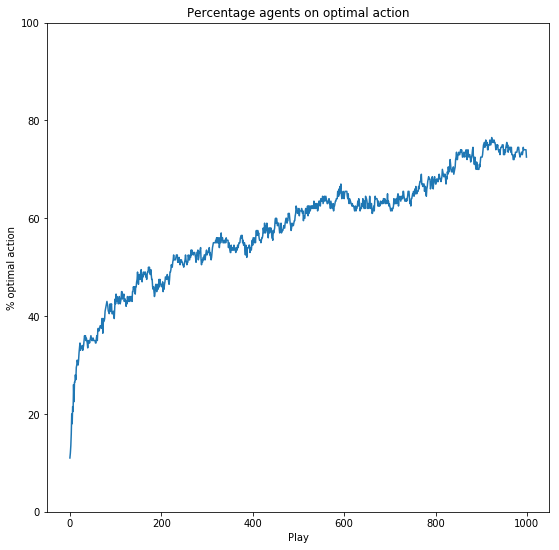

In [38]:
ns_reward_avg2, ns_optimal_actions2 = run(bandit_factory=partial(make_bandit, 10, BanditType=NonStationaryBandit),
                                          agent_factory=partial(make_agent, 10, 0, 
                                                                AgentType=ConstantStepSizeAgent,
                                                                agent_kwargs={'explore_chance': 0.1,
                                                                              'step_size': 0.05}))

### Double the (original) step size

0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 

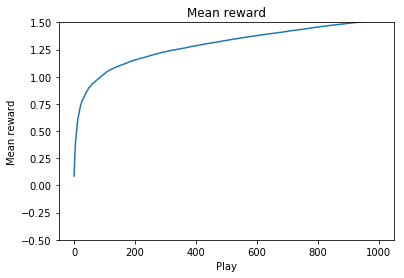

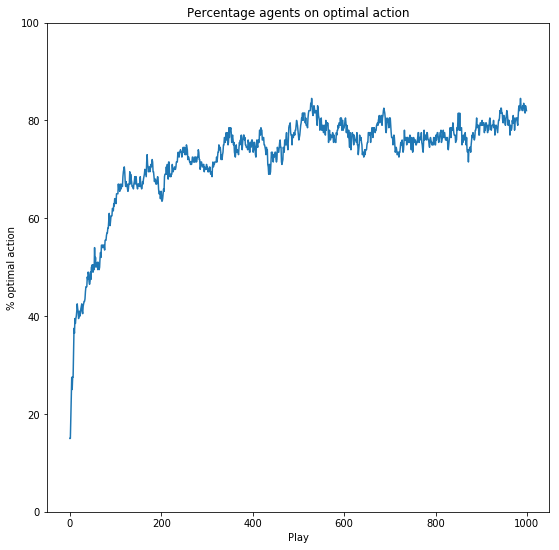

In [39]:
ns_reward_avg2, ns_optimal_actions2 = run(bandit_factory=partial(make_bandit, 10, BanditType=NonStationaryBandit),
                                          agent_factory=partial(make_agent, 10, 0, 
                                                                AgentType=ConstantStepSizeAgent,
                                                                agent_kwargs={'explore_chance': 0.1,
                                                                              'step_size': 0.2}))